In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import glob
import random
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Setup Using TPU Distributed Cluster

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = '/kaggle/input/chest-xray-pneumonia'
#BATCH_SIZE = 64*strategy.num_replicas_in_sync
BATCH_SIZE = 64 # for non-TPU use
IMAGE_SIZE = [180, 180]
EPOCHS = 50

# Combine Train, Validation, and Test Filenames to create a full similar distribution of training, val, and testing

#### As seen in the EDA, there is a severe imbalance of images amongst training, testing and validation.
- Validation only has 16 total images
- Training has 5216 total images
- Testing has 624 total images

As well, the classes are imbalanced amongst the sets:
- Validation set is a **50:50 split of Normal and Pneumonia**
- Training set is **74:26 Pneumonia:Normal**
- Testing set is **63:37 Pneumonia:Normal**. 

**The testing and validation need to have the same distrobution for the model to learn effectively.**

A much better distribution will have all the samples mixed together and then randomly split **60:20:20 for train:val:test**

## Combine the different files and randomly split them

In [51]:
all_filenames = []

for set_name in ['val', 'test', 'train']:
    for class_name in ['PNEUMONIA', 'NORMAL']:

        filenames = glob.glob(GCS_PATH + f'/chest_xray/{set_name}/{class_name}/*')
        all_filenames += filenames
    
len(all_filenames)

5856

In [52]:
# split the data into 60:40 for train:test+val
train_files, val_test_files = train_test_split(all_filenames, test_size=0.4,random_state=18)

In [53]:
# split the val_test_files to 50:50 to have a final split of 60:20:20 of train:val:test
val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=18)

## View the Distribution of Pneumonia and Normal in each set

In [56]:

pct_df = pd.DataFrame(columns = ['data_set', 'label', 'pct'], index = range(6))

totals = {'train':len(train_files), 'val':len(val_files), 'test':len(test_files)}

pneum_count = 0
norm_count = 0

re_pattern = '.*/(NORMAL|PNEUMONIA)/.*'

for file in val_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        norm_count += 1
    else:
        pneum_count += 1

pct_df.iloc[0, :] = ['val', 'NORMAL', round(100* norm_count / totals['val'], 1)]
pct_df.iloc[1, :] = ['val', 'PNEUMONIA', round(100* pneum_count / totals['val'], 1)]


pneum_count = 0
norm_count = 0
for file in test_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        norm_count += 1
    else:
        pneum_count += 1

pct_df.iloc[2, :] = ['test', 'NORMAL', round(100* norm_count / totals['test'], 1)]
pct_df.iloc[3, :] = ['test', 'PNEUMONIA', round(100* pneum_count / totals['test'], 1)]

pneum_count = 0
norm_count = 0
for file in train_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        norm_count += 1
    else:
        pneum_count += 1

pct_df.iloc[4, :] = ['train', 'NORMAL', round(100* norm_count / totals['train'], 1)]
pct_df.iloc[5, :] = ['train', 'PNEUMONIA', round(100* pneum_count / totals['train'], 1)]

In [57]:
pct_df

,data_set,label,pct
0,val,NORMAL,27.6
1,val,PNEUMONIA,72.4
2,test,NORMAL,26.9
3,test,PNEUMONIA,73.1
4,train,NORMAL,26.9
5,train,PNEUMONIA,73.1


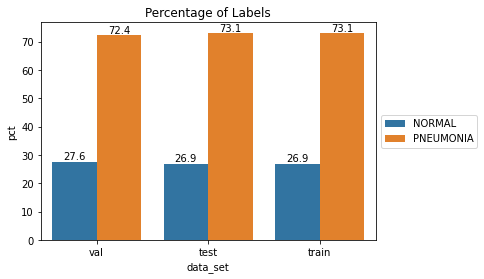

In [61]:
ax = sns.barplot(x=pct_df['data_set'], y=pct_df['pct'], hue=pct_df['label'])
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Percentage of Labels')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

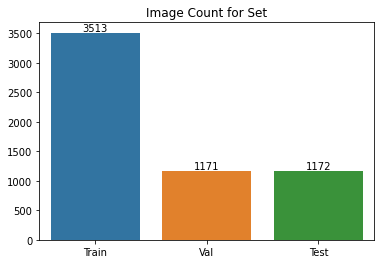

In [62]:
ax = sns.barplot(x=['Train', 'Val', 'Test'], y=[len(train_files), len(val_files), len(test_files)])
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Image Count for Set')
plt.show()

## New Distribution Analysis

This is a much better distribution as the percentage of Pneumonia and Normal is evenly distributed across the different sets. As well, there is a 60:20:20 distribution for train:val:test which should provide better results for modeling

In [63]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_files)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_files)

#view the file paths for training
print('----Training Files----')
for f in train_list_ds.take(5):
    print(f.numpy())
    

----Training Files----
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1590_bacteria_4176.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0509-0001.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0603-0001.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0929-0001.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1642_virus_2842.jpeg'


2023-01-01 00:10:26.304798: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [64]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

print(f'Train Image Count: {TRAIN_IMG_COUNT}\nVal Image Count: {VAL_IMG_COUNT}\nTest Image Count: {TEST_IMG_COUNT}')

Train Image Count: 3513
Val Image Count: 1171
Test Image Count: 1172


## Pre Process the Data

In [ ]:
# will label as 1 if pneumonia otherwise 0
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [ ]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
y_train = []
for image, label in train_ds.take(TRAIN_IMG_COUNT):
    y_train.append(label)
    
print('Training Counts')
print(f'Pneumonia count: {np.sum(y_train)}\nNormal count: {TRAIN_IMG_COUNT - np.sum(y_train)}')

In [ ]:
y_val = []
for image, label in val_ds.take(VAL_IMG_COUNT):
    y_val.append(label)
    
print('Validation Counts')
print(f'Pneumonia count: {np.sum(y_val)}\nNormal count: {VAL_IMG_COUNT - np.sum(y_val)}')

In [ ]:
y_test = []
for image, label in test_ds.take(TEST_IMG_COUNT):
    y_test.append(label)
    
print('Test Counts')
print(f'Pneumonia count: {np.sum(y_test)}\nNormal count: {TEST_IMG_COUNT - np.sum(y_test)}')

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

## View Some of the Images

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Create Weights for the Image Class Imbalance

In [ ]:
initial_bias = np.log([PNEUMONIA_COUNT/NORMAL_COUNT])
initial_bias

In [ ]:
weight_for_0 = (1 / NORMAL_COUNT)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / PNEUMONIA_COUNT)*(TRAIN_IMG_COUNT)/2.0

In [ ]:
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

### Build the Model and Train it

In [ ]:
with strategy.scope():
    
    base_model = tf.keras.applications.inception_v3.InceptionV3(
                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                include_top=False,
                weights='imagenet'
                )
    base_model.trainable = False
    
    x=base_model.output
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
    
    model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
             )

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
                   train_ds,
                   steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                   class_weight=class_weight,
                   callbacks=[checkpoint_cb, early_stopping_cb]
                   )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_'+metric])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])
    

In [ ]:
with strategy.scope():
    
    base_model = tf.keras.applications.inception_v3.InceptionV3(
                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                include_top=False,
                weights='imagenet'
                )
    base_model.trainable = False
    
    x=base_model.output
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        ]
    
    model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
             )

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
for _ in range(8):
    
    with strategy.scope():
    
        base_model = tf.keras.applications.inception_v3.InceptionV3(
                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                include_top=False,
                weights='imagenet'
                )
        base_model.trainable = False
    
        x=base_model.output
        inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        x = base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.Model(inputs, outputs)

    
    
        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
            ]
    
        model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=METRICS
                 )
    
    
    r = -4 * random.random()
    learning_rate = 10 ** r

    exponential_decay_fn = exponential_decay(learning_rate, 20)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

    print(f'Training: Learning Rate = {learning_rate}')
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"xray_model_{learning_rate}.h5", save_best_only=True)

    history = model.fit(
                train_ds,
                steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                epochs=25,
                validation_data=val_ds,
                validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                class_weight=class_weight,
                callbacks=[lr_scheduler, checkpoint_cb, early_stopping_cb])
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history['val_'+metric])
        ax[i].set_title(f'Model {metric}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metric)
        ax[i].legend(['train', 'val'])
        
    print(f'Training Complete for {learning_rate}\n\n\n')
    
    test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
    TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)
    
    results = model.evaluate(test_ds)
    
    print(f'Test set results for {learning_rate}: {results}')
    
    print('\n\n\n')

## Try on different number of hidden units and mini-batch sizes

In [ ]:
for _ in range(4):
    r = -2 **  random.random()
    learning_rate = 10 ** r
    for mini_batch_size in [128, 256, 512]:
        for hidden_units in [64, 128, 256, 512]:
    
            with strategy.scope():
    
                base_model = tf.keras.applications.inception_v3.InceptionV3(
                    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                    include_top=False,
                    weights='imagenet'
                    )
                base_model.trainable = False
    
                x=base_model.output
                inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
                x = base_model(inputs, training=False)
                x = tf.keras.layers.GlobalAveragePooling2D()(x)
                x = tf.keras.layers.Dropout(0.3)(x)
                x = tf.keras.layers.Dense(hidden_units)(x)
                x = tf.keras.layers.BatchNormalization()(x)
                x = tf.keras.layers.Dropout(0.3)(x)
                outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
                model = tf.keras.Model(inputs, outputs)

    
    
                METRICS = [
                    'accuracy',
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')
                    ]
    
                model.compile(
                    optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=METRICS
                     )
    

                exponential_decay_fn = exponential_decay(learning_rate, 20)

                lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

                print(f'Training: Learning Rate = {learning_rate}\nHidden Units = {hidden_units}\nMini Batch Size = {mini_batch_size}')
    
                label_lr = round(learning_rate, 3)
    
    
                checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"xray_model_{mini_batch_size}_{hidden_units}_{label_lr}.h5", save_best_only=True)

                BATCH_SIZE = mini_batch_size
    
                history = model.fit(
                        train_ds,
                        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                        epochs=50,
                        validation_data=val_ds,
                        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                        class_weight=class_weight,
                        callbacks=[lr_scheduler, checkpoint_cb, early_stopping_cb])
    
                fig, ax = plt.subplots(1, 4, figsize=(20, 3))
                ax = ax.ravel()

                for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
                    ax[i].plot(history.history[metric])
                    ax[i].plot(history.history['val_'+metric])
                    ax[i].set_title(f'Model {metric}')
                    ax[i].set_xlabel('epochs')
                    ax[i].set_ylabel(metric)
                    ax[i].legend(['train', 'val'])
        
                    print(f'Training Complete\nLearning Rate = {learning_rate}\nHidden Units = {hidden_units}\nMini Batch Size = {mini_batch_size}\n\n\n')
    
                test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
                TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
                test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
                test_ds = test_ds.batch(BATCH_SIZE)
    
                results = model.evaluate(test_ds)
    
                print(f'Test set results for {learning_rate}: {results}\n\n\n')
    


## Evaluate Model on Test Set

In [ ]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

In [ ]:
results = model.evaluate(test_ds)

In [ ]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
y_preds = model.predict(test_ds, batch_size = BATCH_SIZE, verbose = True)

len(y_preds)


### Try different Thresholds

In [ ]:
from sklearn.metrics import classification_report

y_preds_filtered = [1 if pred > 0.5 else 0 for pred in y_preds]

class_report = classification_report(y_test, y_preds_filtered)
print(class_report)

In [ ]:
# build a function for AUC 
def plot_auc(t_y, p_y):
    
    fpr, tpr, threshold = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
    return plt.show()